### 🔹 1. Imports and Initial Setup

📘 *In this section, we import all necessary Python modules and helper functions from the project. We also configure the plot style for consistency.*

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa

import sys
sys.path.append('..')
sys.path.append('src')

from src.chroma_features import compute_chromagram_from_filename
from src.chroma_features import normalize_feature_sequence
from src.chord_templates import generate_chord_templates, get_chord_labels
from src.chord_recognition import chord_recognition_template
from src.io_utils import read_chord_annotation, annotation_to_frame_matrix
from src.evaluation import compute_eval_measures
from src.plotting import plot_chromagram, plot_binary_time_chord, plot_eval_matrix

plt.style.use('ggplot')

### 🔹 2. Load Audio and Compute Chromagram

📘 *We load a `.wav` file and compute its chromagram representation. The chromagram captures the intensity of each pitch class (C, C#, ..., B) over time, and is used as input for chord recognition.*

In [7]:
fn_wav = '/home/cepatinog/ethnomusic/amplab-musicology-andina/annotations/rh_0002.wav'  # ← change this to the actual path

X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(
    fn_wav, sr=22050, N=4096*4, H=2048*4, gamma=0.1, version='STFT', norm='2'
)

print(f'Cromagram shape: {X.shape}, Fs_X: {Fs_X:.2f}, Duration: {x_dur:.2f} s')

Cromagram shape: (12, 51), Fs_X: 2.69, Duration: 18.81 s


### 🔹 3. Plot Waveform and Chromagram

📘 *We visualize the waveform and the chromagram of the audio file to better understand its temporal and harmonic structure.*

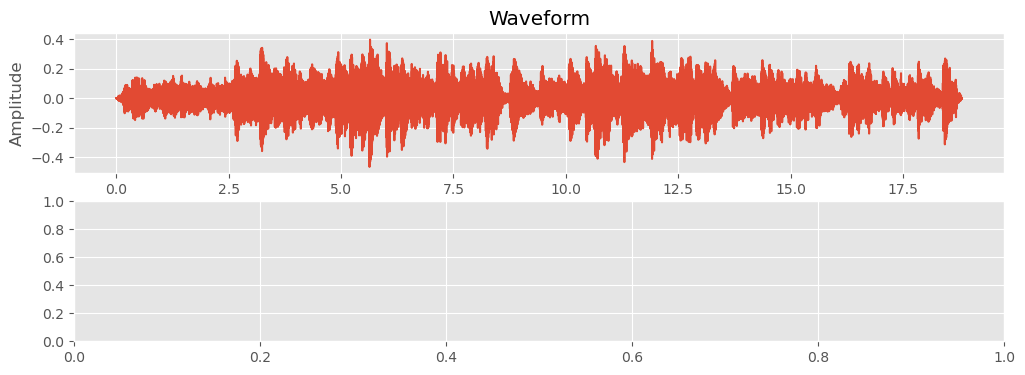

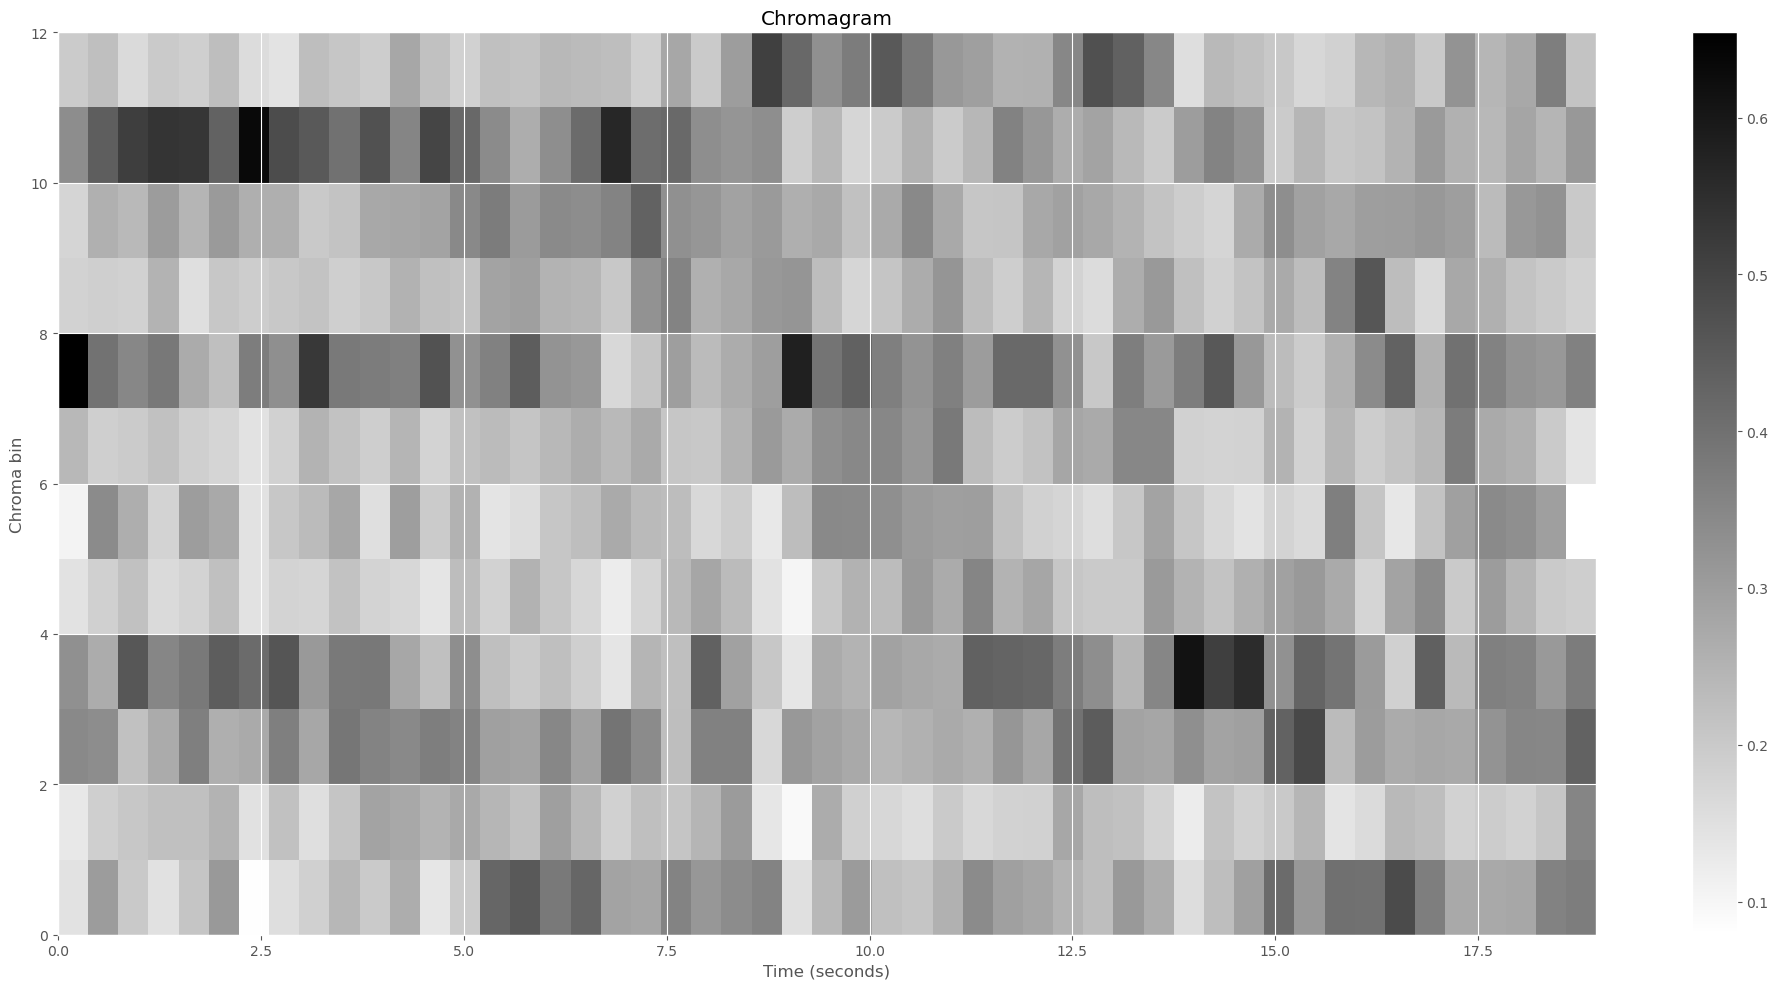

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
plt.plot(np.linspace(0, x_dur, len(x)), x)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plot_chromagram(X, sr_feature=Fs_X)
plt.tight_layout()
plt.show()

### 🔹 4. Chord Recognition

📘 *We compare each chroma vector against predefined chord templates to identify the most likely chord for each frame. The result is a binary matrix indicating the most similar chord per frame.*

In [9]:
chord_sim, chord_max = chord_recognition_template(X, norm_sim='1', nonchord=False)
chord_labels = get_chord_labels(nonchord=False)

### 🔹 5. Visualize Chord Recognition Result

📘 *This plot shows the estimated chord at each frame. The vertical axis corresponds to all possible chords, and a black mark indicates a chord was selected at a given time.*

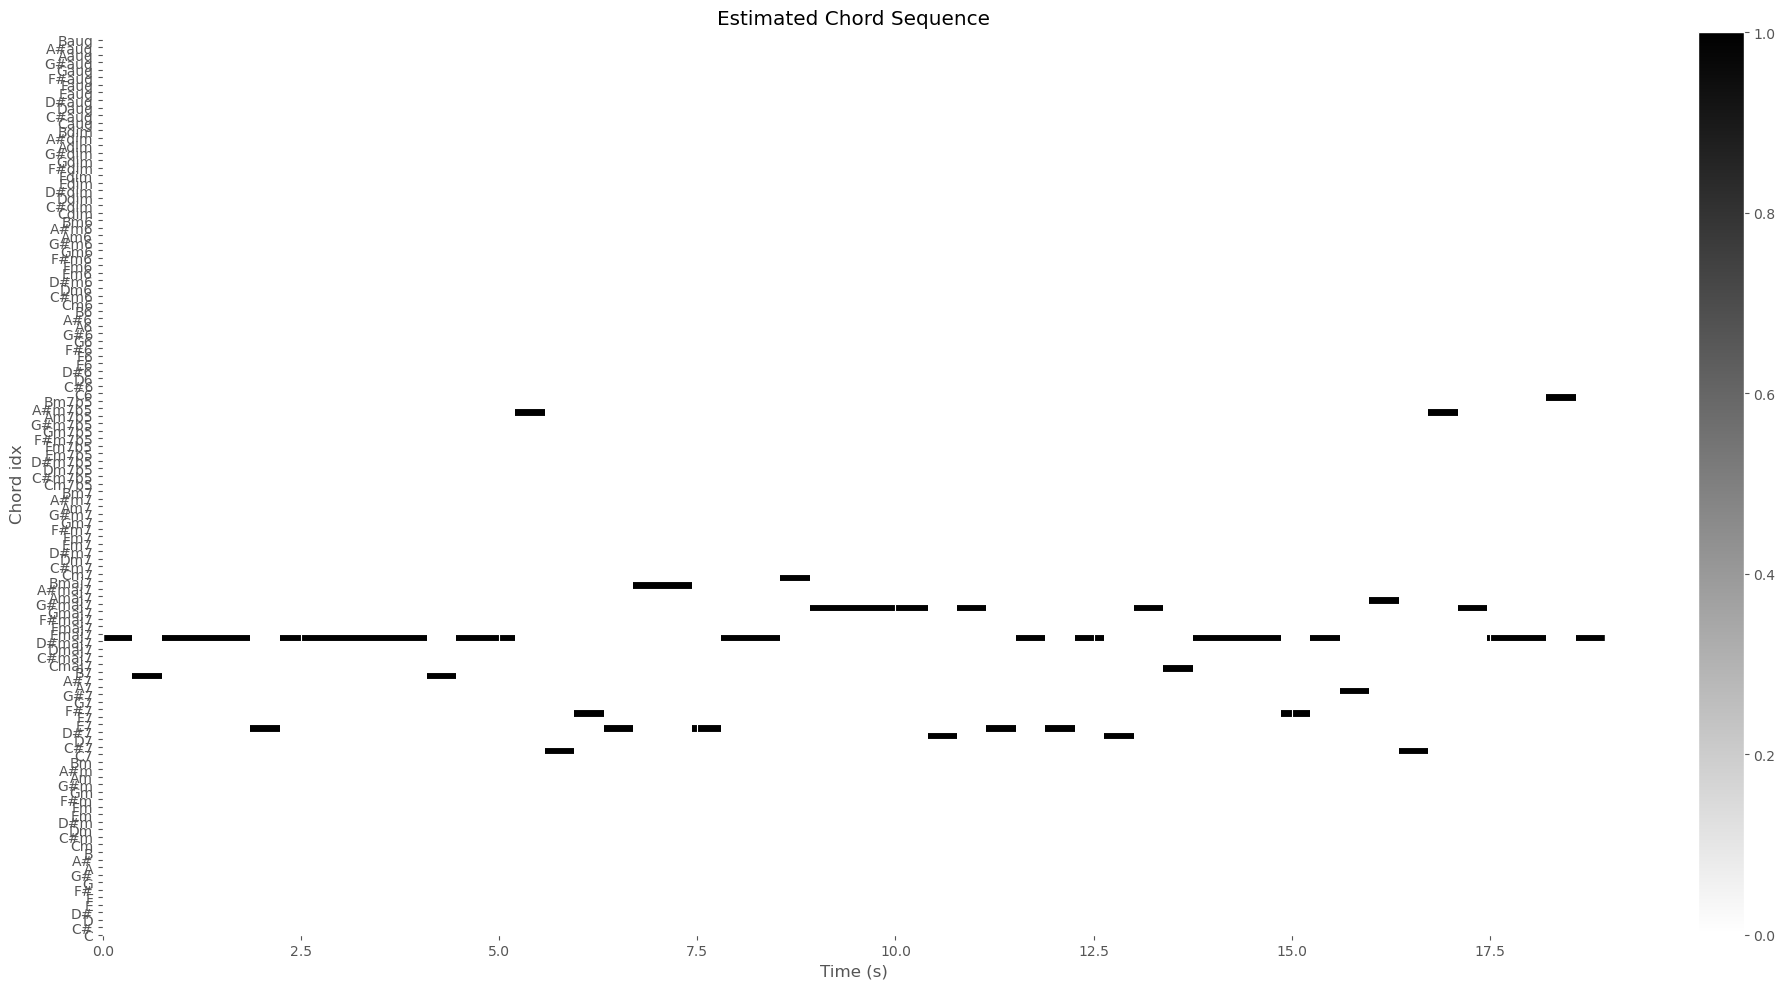

In [10]:
plot_binary_time_chord(chord_max, chord_labels=chord_labels, sr_feature=Fs_X,
                       title="Estimated Chord Sequence")
plt.show()

### 🔹 6. Load Reference Annotation and Convert to Matrix

📘 *We load a ground-truth annotation file in CSV format and convert it into a binary frame-level matrix aligned with the chromagram.*

In [11]:
fn_csv = fn_wav.replace('.wav', '.csv')  # or specify it directly
segments = read_chord_annotation(fn_csv)
N_frames = X.shape[1]

I_ref = annotation_to_frame_matrix(segments, chord_labels, N_frames, Fs_X)

### 🔹 7. Quantitative Evaluation

📘 *We evaluate the chord recognition system using standard metrics: Precision, Recall, and F-measure. These metrics are computed by comparing the estimated chord matrix against the reference matrix.*

In [12]:
P, R, F, TP, FP, FN = compute_eval_measures(I_ref, chord_max)

print(f"Precision: {P:.3f}, Recall: {R:.3f}, F1-score: {F:.3f}")
print(f"TP: {TP}, FP: {FP}, FN: {FN}")

Precision: 0.000, Recall: 0.000, F1-score: 0.000
TP: 0, FP: 51.0, FN: 20


### 🔹 8. Visual Evaluation Matrix

📘 *This matrix highlights true positives (TP), false positives (FP), and false negatives (FN) in different colors, providing a visual summary of the system's accuracy across time and chord classes.*

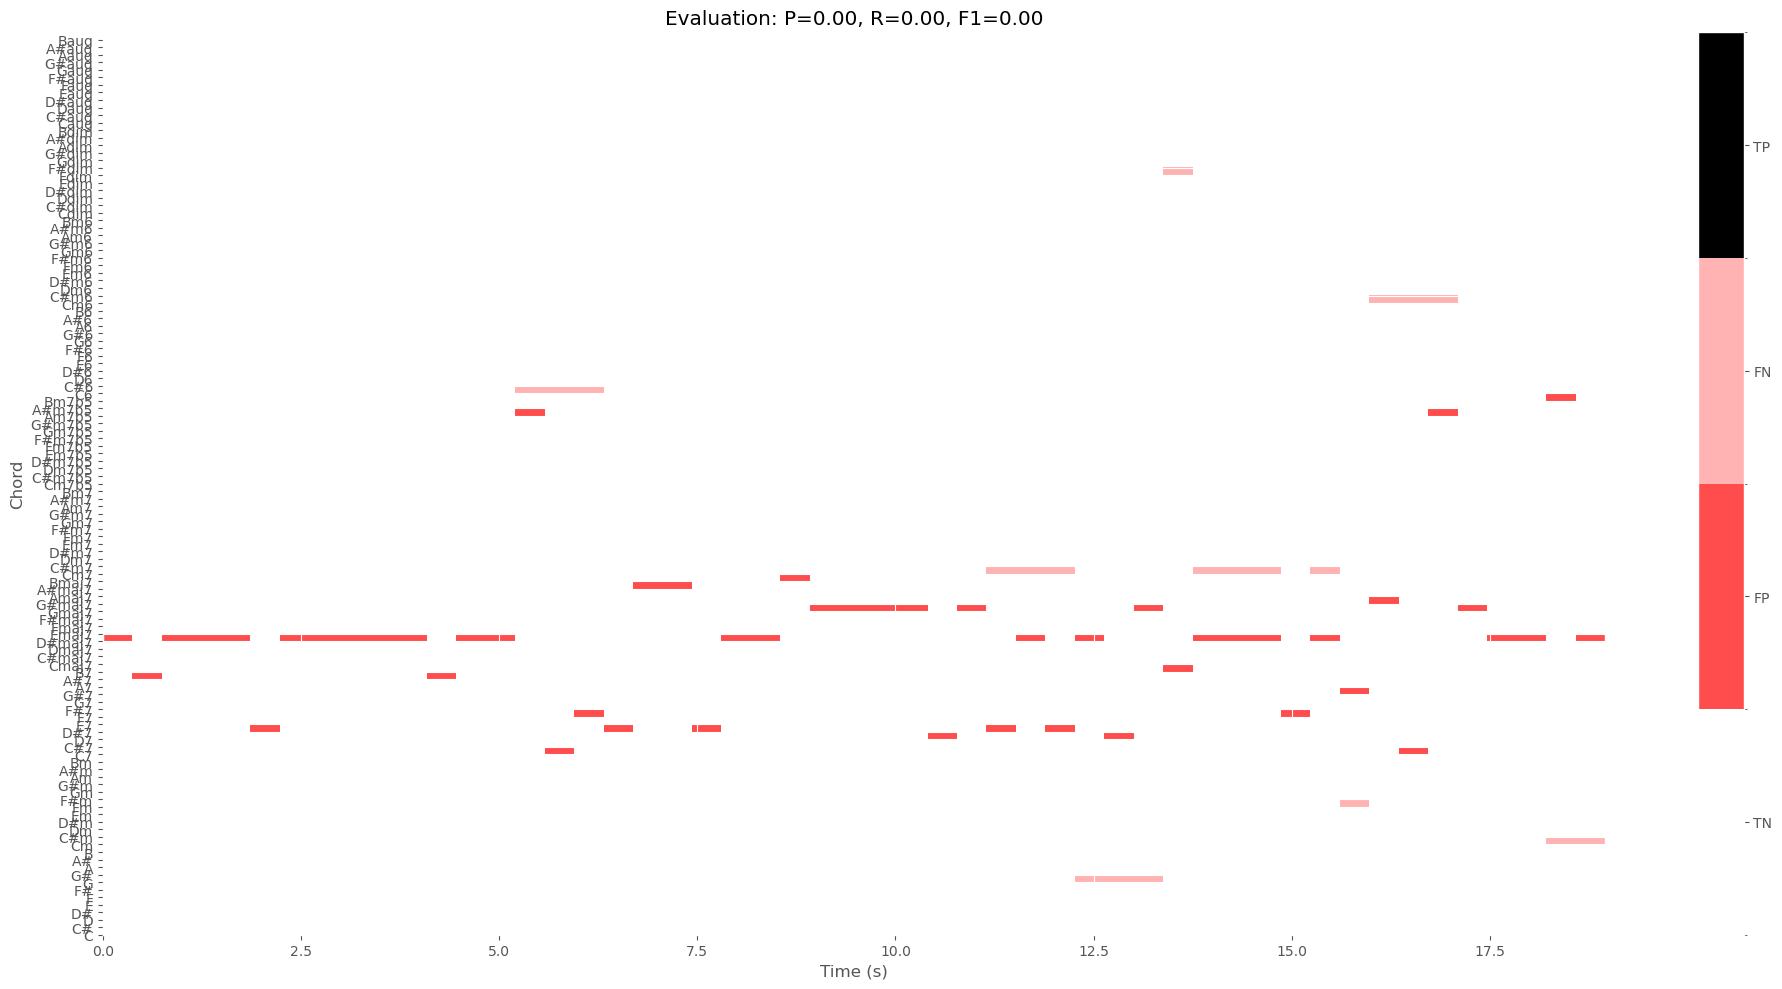

In [13]:
plot_eval_matrix(I_ref, chord_max, sr_feature=Fs_X, chord_labels=chord_labels,
                 title=f"Evaluation: P={P:.2f}, R={R:.2f}, F1={F:.2f}")
plt.show()

### 🔹 9. Export Estimated Chords to CSV

📘 *We export the final chord sequence (frame-by-frame) into a CSV file, with each line representing a timestamp and the corresponding predicted chord.*

In [14]:
from src.io_utils import save_chord_sequence_to_csv

hop_time = 2048 / Fs
times = np.arange(N_frames) * hop_time
chord_seq = [chord_labels[np.argmax(chord_max[:, i])] for i in range(N_frames)]

out_csv = fn_wav.replace('.wav', '_predicted_chords.csv')
save_chord_sequence_to_csv(times, chord_seq, out_csv)

print(f"Saved predicted chord sequence to: {out_csv}")

Saved predicted chord sequence to: /home/cepatinog/ethnomusic/amplab-musicology-andina/annotations/rh_0002_predicted_chords.csv


### 🔹 10. Chord Distribution Histogram

📘 *We analyze how frequently each chord appears in the estimated sequence. This helps identify chord bias or imbalances.*

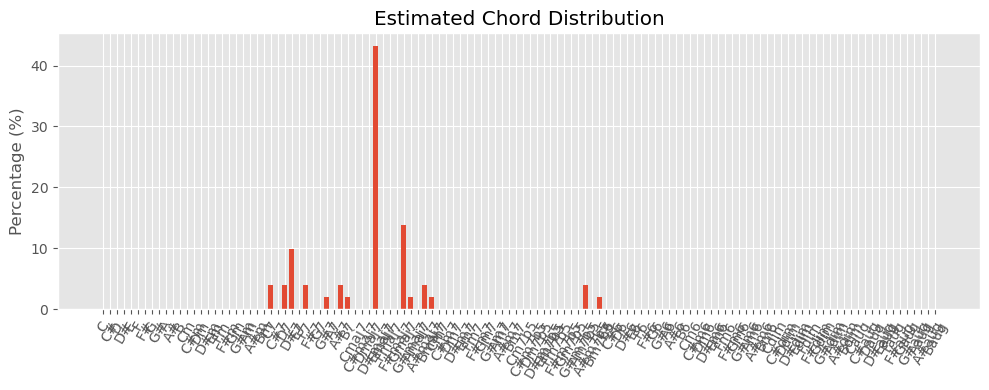

In [15]:
row_sums = chord_max.sum(axis=1)
total = row_sums.sum()
percent = 100.0 * row_sums / total

plt.figure(figsize=(10, 4))
plt.bar(chord_labels, percent)
plt.xticks(rotation=60)
plt.ylabel("Percentage (%)")
plt.title("Estimated Chord Distribution")
plt.tight_layout()
plt.show()